The equation 
$$ \omega^2\tilde{v}(z) + 2i\omega\tilde{v}'(z) + (1-v_0^2)\tilde{v}''(z) = 0, \tilde{v}(-1) = \tilde{v}(1) = 0 $$
can be reduced to normal form
$$ u''(z) + r(z)u(z) = 0, u(-1) = u(1) = 0 $$
by doing the following variable change
$$
u(z) = \exp\left(\frac{iv_0\omega}{1-v_0^2}\right)\tilde{v}(z); \;\;\;
r(z) = \frac{\omega^2}{(1-v_0^2)^2}
$$
For the details, please read this blog,
[Eliminates first order term](https://www.johndcook.com/blog/2017/10/20/eliminate-first-order-term/)

In [38]:
import numpy as np
from nozzle import Spectral, Params, Nozzle, Boundary

[ 1.1780488   2.35580693  3.5329838   4.70928896  5.88443218  7.0581235
  8.23007333  9.39999252 10.5675924  11.73258488 12.89468252 14.05359859
 15.20904715 16.3607431  17.50840229 18.65174154 19.79047875 20.92433295
 22.05302439 23.17627458 24.29380636 25.40534402 26.51061328 27.60934145
 28.70125743 29.7860918  30.8635769  31.93344687 32.99543774 34.04928748
 35.09473607 36.13152556 37.15940013 38.17810618 39.18739235 40.18700962
 41.17671135 42.15625334 43.1253939  44.08389392 45.0315169  45.96802902
 46.89319923 47.80679923 48.70860362 49.5983899 ]


/home/huntfeng/research/magnetic_nozzle/nozzle.py:279: RuntimeWarning: invalid value encountered in divide
  ax.plot(self.x, self.V[:,i].imag/np.abs(self.V[:,i].imag).max(), '--', color=line[-1].get_color())


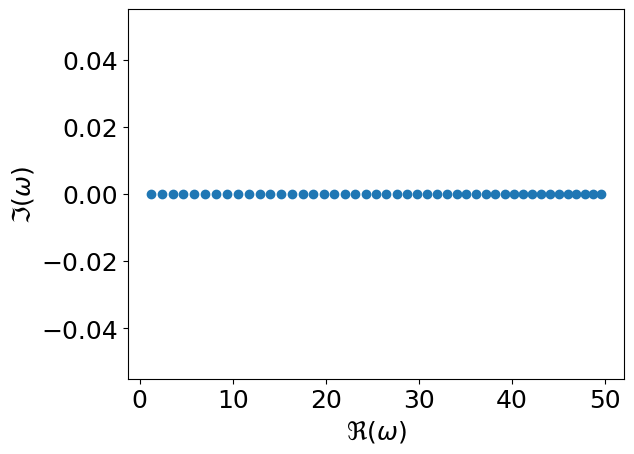

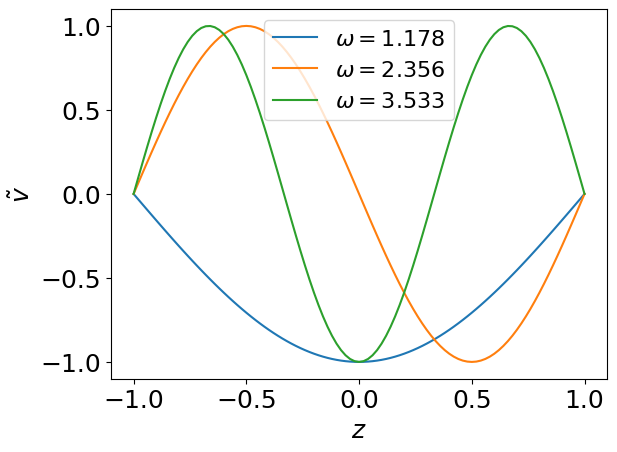

In [62]:
N = 101
v0 = 0.5
spectral = Spectral(N,"symmetric", "FD")

x = spectral.x
D2 = spectral.D2

A2 = np.eye(N)[1:-1,1:-1]
A1 = np.zeros_like(A2)
A0 = (1-v0**2)**2*D2[1:-1,1:-1]

params = Params(Mm=v0, constant_v=True)
nozzle = Nozzle(params, x)
V, nozzle.omega = nozzle.solve(A0,A1,A2)
nozzle.V = np.pad(V, ((1,1),(0,0)))
nozzle.sort_solutions()
nozzle.plot_eigenvalues()
nozzle.plot_eigenfunctions()

print(nozzle.omega)

Let 

$$
u(z) = \exp\left(\frac{1}{2}\int^x dt \frac{2i\omega v_0 - v_0'(3v_0 + 1/v_0)}{1-v_0^2}\right) v(z)
$$

then we get the normal form
$$
u'' + r(z;\omega)u = 0
$$
where 
$$
r(z;\omega) = \frac{1}{(1-v_0^2)^2} \left[ \omega^2 + 2i\omega v_0^2 v_0' 
+ (v_0')^2\left(-\frac{1}{2} + \frac{1}{4v_0^2} + \frac{v_0^2}{4}\right) 
+ v_0''\left(-\frac{1}{2v_0} + v_0 - \frac{5}{2}v_0^3\right) 
\right]
$$

- For $v(-1)=v(1)=0$, the corresponding BC is $u(-1)=u(1)=0$.
- For $v(-1)=v'(1)=0$, the corresponding BC is $u(-1)=0$ and the right-end is a mixed condition,
$$
u'(1) - \left. \frac{1}{2} \frac{2i\omega v_0 - v_0'(3v_0 + 1/v_0)}{1-v_0^2}\right|_{z=1} u(1) = 0
$$

In [40]:
import matplotlib.pyplot as plt
from scipy.optimize import root
from tqdm import tqdm

def rk4(f: callable, y0: np.array, t: np.array):
    """ RK4 with fixed time step """
    dt = t[1] - t[0]
    y = np.zeros((y0.size, t.size), dtype=y0.dtype)
    y[:,0] = y0
    for n in range(t.size-1):
        yn = y[:,n]
        tn = t[n]
        k1 = f(tn, yn)
        k2 = f(tn+dt/2, yn + dt*k1/2)
        k3 = f(tn+dt/2, yn + dt*k2/2)
        k4 = f(tn+dt, yn + dt*k3)
        y[:,n+1] = yn + dt*(k1+2*k2+2*k3+k4)/6
    return t, y

In [65]:
N = 101
Mm = 0.5
constant_v = True
accelerating = False
boundary = Boundary.FIXED_FIXED

spectral = Spectral(N,"symmetric", "FD")
x = spectral.x
D1 = spectral.D1
D2 = spectral.D2
params = Params(Mm,constant_v, accelerating)
nozzle = Nozzle(params, x)
v0 = nozzle.v0
v0_p = D1@v0
v0_pp = D2@v0

def nozzle_ivp(z,y, w):
    """ return R.H.S. of the coupled first order system at a point """
    ind = np.argmin(np.abs(spectral.x-z))
    r = 1/(1-v0[ind]**2)**2 * ( 
        w**2 + 2j*w*v0[ind]**2*v0_p[ind]
        + v0_p[ind]**2*(-1/2 + 1/(4*v0[ind]**2) + v0[ind]**2/4) 
        + v0_pp[ind]*(-1/(2*v0[ind]) + v0[ind] - 5/2*v0[ind]**3) 
    )
    return np.array([
        y[1],
        -r*y[0]
    ])

def nozzle_rfp(w):
    """ Given eigenvalue w (in array form), returns v(1) or v'(1) """
    w = w[0] + w[1]*1j
    y0 = np.array([0,1],dtype=complex)
    z, y = rk4(lambda z,y: nozzle_ivp(z,y,w), y0, x)
    if boundary == Boundary.FIXED_FIXED:
        return np.array([y[0,-1].real, y[0,-1].imag])
    else:
        # TODO, do this later
        pass

omega0_arr = [2+0j, 5+0j, 10+0j, 15+0j]
omega = np.zeros_like(omega0_arr)
for n, w0 in enumerate(tqdm(omega0_arr)):
    w0 = np.array([w0.real, w0.imag])
    result = root(nozzle_rfp, w0, tol=1e-12)
    print(result.success) 
    w = result.x
    omega[n] = w[0]+w[1]*1j

 50%|█████     | 2/4 [00:00<00:00,  7.20it/s]

True
True


/tmp/ipykernel_11640/128354960.py:27: RuntimeWarning: overflow encountered in cdouble_scalars
  -r*y[0]
/tmp/ipykernel_11640/2487580612.py:17: RuntimeWarning: invalid value encountered in multiply
  y[:,n+1] = yn + dt*(k1+2*k2+2*k3+k4)/6
/tmp/ipykernel_11640/2487580612.py:17: RuntimeWarning: invalid value encountered in divide
  y[:,n+1] = yn + dt*(k1+2*k2+2*k3+k4)/6
/tmp/ipykernel_11640/2487580612.py:14: RuntimeWarning: invalid value encountered in multiply
  k2 = f(tn+dt/2, yn + dt*k1/2)
/tmp/ipykernel_11640/2487580612.py:14: RuntimeWarning: invalid value encountered in divide
  k2 = f(tn+dt/2, yn + dt*k1/2)
100%|██████████| 4/4 [00:00<00:00,  8.24it/s]

False
True


/tmp/ipykernel_11640/100690143.py:10: RuntimeWarning: invalid value encountered in divide
  plt.plot(z, u.imag / np.abs(u.imag).max() , "--", color=line[-1].get_color())


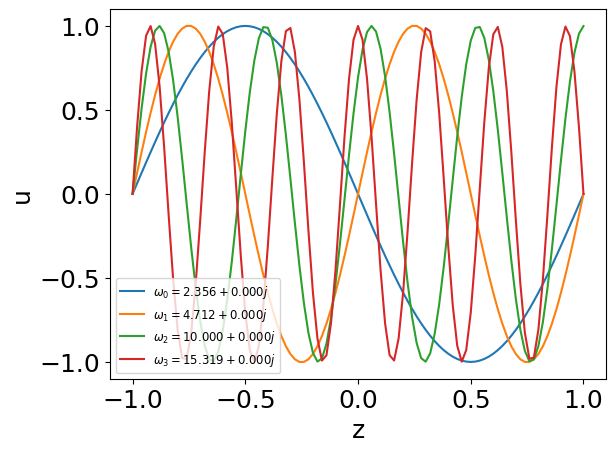

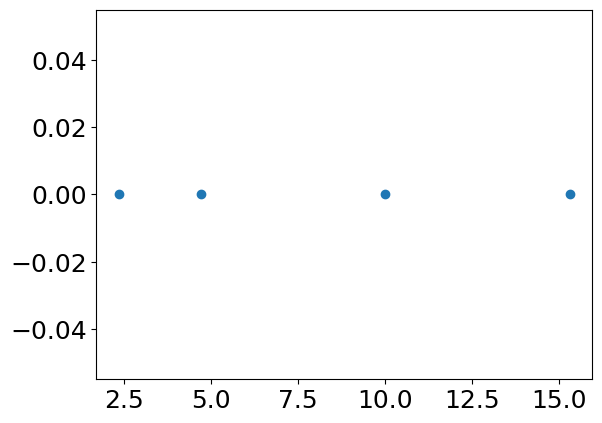

In [66]:
plt.figure()
for n, w in enumerate(omega):
    z, y = rk4(
        lambda z,y: nozzle_ivp(z,y, w),
        np.array([0,1], dtype=complex),
        x
    )
    u = y[0]
    line = plt.plot(z, u.real / np.abs(u.real).max(), label=f"$\omega_{n}={omega[n]:.3f}$")
    plt.plot(z, u.imag / np.abs(u.imag).max() , "--", color=line[-1].get_color())
plt.legend(fontsize="small")
plt.xlabel("z")
plt.ylabel("u")

plt.figure()
plt.plot(omega.real, omega.imag, 'o')

In [1]:
import sympy as sp

In [2]:
x = sp.Symbol("x")
M = sp.Function("M")(x)

sp.integrate(1/(1-M**2)).diff(x,1)

-1/(M(x)**2 - 1)